In [1]:
import os
import sys
sys.path.append(os.getcwd().rstrip('notebooks'))
sys.path.append(os.getcwd().rstrip('notebooks') + '/PixelCNN')
os.chdir(os.getcwd().rstrip('notebooks'))

import torch
import torch.nn.functional as F
from torch import optim
from utils import *
from model import *
from PixelCNN.network import *
import numpy as np
from tqdm import tqdm


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
opt = {}
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    opt["device"] = torch.device("cuda:0")
    opt["if_cuda"] = True
else:
    opt["device"] = torch.device("cpu")
    opt["if_cuda"] = False

opt['data_set'] = 'latent'
opt['x_dis'] = 'Logistic'  ## or MixLogistic
opt['z_channels'] = 2  ## 2*64
opt['epochs'] = 100
opt['dataset_path'] = f"./save/latent_CIFAR_{opt['z_channels']}.pickle"
opt['save_path'] = './save/'
opt['result_path'] = './result/'
opt['batch_size'] = 100
opt['test_batch_size'] = 200
opt['if_regularizer'] = False
opt['load_model'] = False
opt['lr'] = 1e-4
opt['data_aug'] = False
opt["seed"] = 0
opt['if_save_model'] = True
opt['save_epoch'] = 50
opt['additional_epochs'] = 100
opt['sample_size'] = 100
opt['if_save_latent'] = True
opt["c_hidden"] = 128
opt['layer_num'] = 15
opt['visualize'] = True
np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])
eps = 1e-7

train_data, test_data, train_data_evaluation = LoadData(opt)
latent_data_shape = [-1, opt['z_channels'], 8, 8]

model = PixelCNN(device = opt['device'], c_in=latent_data_shape[1] * 2, c_hidden=opt['c_hidden'], layer_num=opt['layer_num']).to(opt["device"])
model.load_state_dict(torch.load(f"./save/pixelcnn_{opt['z_channels']}.pth"))

Loading latent block data
Done loading latent block data
Loading latent block data
Done loading latent block data


<All keys matched successfully>

In [3]:
model.eval()
with torch.no_grad():
    for z_mean, z_std in tqdm(train_data):
        z_mean = z_mean.reshape(latent_data_shape).to(opt["device"])
        z_std = z_std.reshape(latent_data_shape).to(opt["device"])
        z = torch.cat((z_mean, z_std), dim=1)
        z_hat_mean, z_hat_std = model.forward(z)

        z_mean = z_mean.view([-1, np.prod(latent_data_shape[1:])])
        z_std = z_std.view([-1, np.prod(latent_data_shape[1:])])
        z_hat_mean = z_hat_mean.view([-1, np.prod(latent_data_shape[1:])])
        z_hat_std = z_hat_std.view([-1, np.prod(latent_data_shape[1:])])

        kl = (torch.log(z_hat_std + eps) - torch.log(z_std + eps) + (z_std ** 2 + (z_mean - z_hat_mean) ** 2) / (2 * z_hat_std ** 2) - 0.5).sum(1).mean(0)
        break

  0%|                                                                                                                                                    | 0/500 [00:00<?, ?it/s]


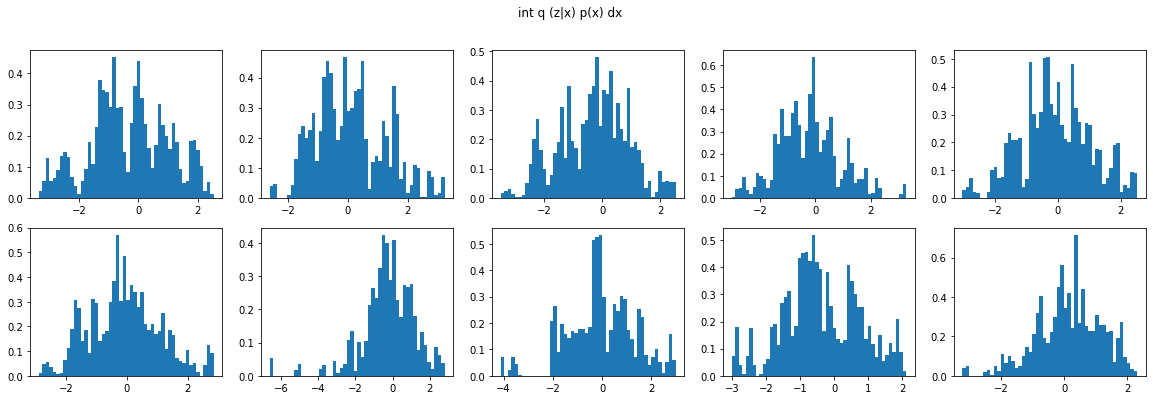

In [4]:
z_dim = np.prod(latent_data_shape[1:])
x_num = z_mean.shape[0]
z_mean = z_mean.reshape([-1, z_dim]).to("cpu")
z_std = z_std.reshape([-1, z_dim]).to("cpu")
sample_num = 20

samples_list = []
for j in range(x_num):
    temp_mean = z_mean[j, :][None, :]
    temp_std = z_std[j, :][None, :]
    epsilon = torch.randn(sample_num, z_dim)
    samples = temp_mean + temp_std * epsilon
    samples_list.append(samples)


samples_array = torch.cat(samples_list, dim=0) ## (x_num * sample_num) * z_dim

fig, ax = plt.subplots(2, 5, figsize=(20, 6))
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].hist(samples_array[:, i].numpy(), bins=50, density=True)

plt.suptitle("int q (z|x) p(x) dx")
plt.show()

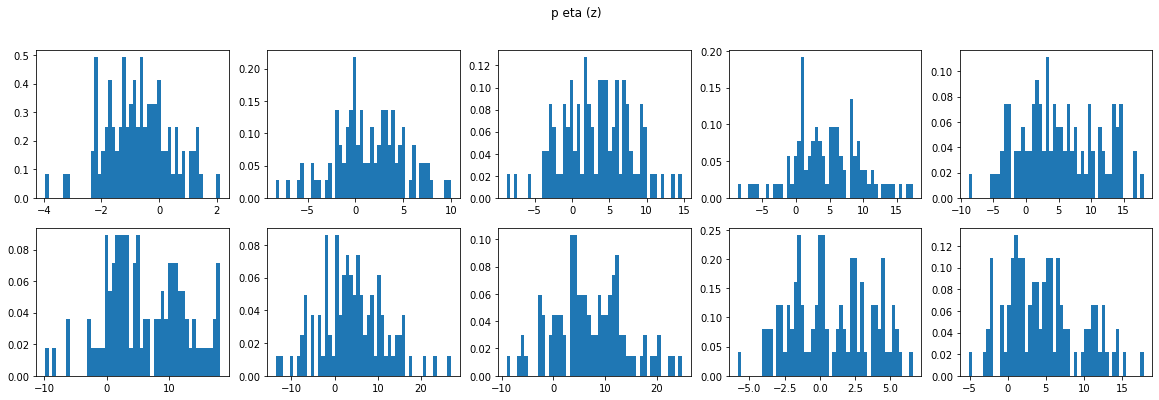

In [5]:
with torch.no_grad():
    gen_img_shape = [100] + [latent_data_shape[1] * 2] + latent_data_shape[2:]
    gen_z, (gen_z_mean, gen_z_std) = model.sample(img_shape=gen_img_shape)
    gen_z = gen_z.reshape(100, z_dim).to("cpu")

fig, ax = plt.subplots(2, 5, figsize=(20, 6))
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].hist(gen_z[:, i].numpy(), bins=50, density=True)

plt.suptitle("p eta (z)")
plt.show()